<a href="https://colab.research.google.com/github/alexandrufalk/Background-generator/blob/Layout-page/SSD_Single_Shot_MultiBox_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
!pip install kaggle
import os
from PIL import Image

#Data preprocessing

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Move the Kaggle JSON from your Google Drive to the right directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Datasets/kaggle_json/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Mounted at /content/drive


In [9]:
!kaggle datasets download -d gopalbhattrai/pascal-voc-2012-dataset


Dataset URL: https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset
License(s): unknown
100% 3.51G/3.52G [00:58<00:00, 150MB/s]
100% 3.52G/3.52G [00:59<00:00, 64.1MB/s]


In [10]:
!unzip pascal-voc-2012-dataset.zip -d ./voc2012


Streaming output truncated to the last 5000 lines.
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001874.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001876.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001882.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001885.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001895.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001896.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001926.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001966.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001971.png  
  inflating: ./voc2012/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_001992.png  

# Load Images

Total number of files test: 16135
Total number of files train: 17125


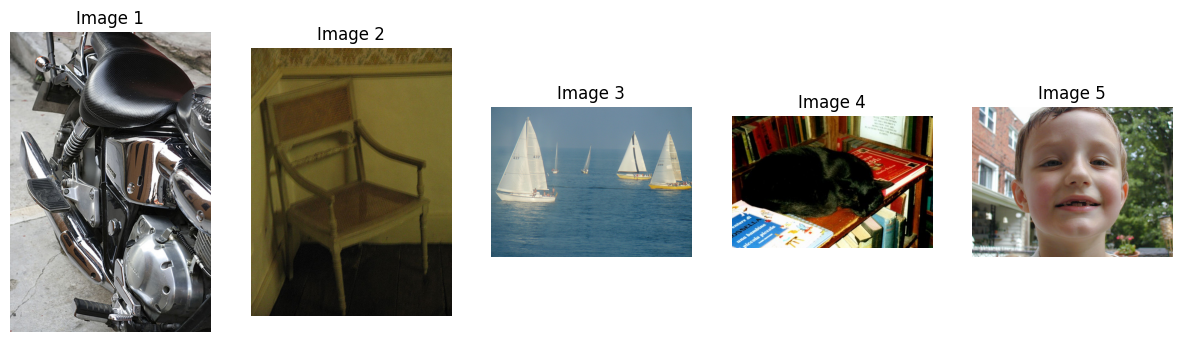

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_dir_test = '/content/voc2012/VOC2012_test/VOC2012_test/JPEGImages'
image_files_test = [os.path.join(image_dir_test, file) for file in os.listdir(image_dir_test)]
num_files_image_test = len(image_files_test)
print(f'Total number of files test: {num_files_image_test}')

image_dir_train = '/content/voc2012/VOC2012_train_val/VOC2012_train_val/JPEGImages'
image_files_train = [os.path.join(image_dir_train, file) for file in os.listdir(image_dir_train)]
num_files_image_train = len(image_files_train)
print(f'Total number of files train: {num_files_image_train}')

# Example of loading one image
img = Image.open(image_files_test[0])

# Display the image
# Get a sorted list of the first 5 image filenames
img_files = sorted(os.listdir(image_dir_test))[:5]

# Plot each of the first 5 images
plt.figure(figsize=(15, 5))
for i, img_file in enumerate(img_files):
    # Load the image
    img_path = os.path.join(image_dir_test, img_file)
    img = Image.open(img_path)

    # Display the image
    plt.subplot(1, 5, i + 1)  # Create a subplot for each image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f'Image {i+1}')  # Add a title to each image

plt.show()


#Parse the Annotations

In [12]:
import xml.etree.ElementTree as ET

def extract_boxes_labels(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = []
    labels = []


    # Extract bounding boxes and labels
    for obj in root.findall('object'):
        label = obj.find('name').text

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)
    filename=root.find('filename').text

    return boxes, labels,filename

annotation_dir_test = '/content/voc2012/VOC2012_test/VOC2012_test/Annotations'
annotation_files_test = [os.path.join(annotation_dir_test, file) for file in os.listdir(annotation_dir_test)]
num_files_annotation_test = len(annotation_files_test)
annotation_dir_train = '/content/voc2012/VOC2012_train_val/VOC2012_train_val/Annotations'
annotation_files_train = [os.path.join(annotation_dir_train, file) for file in os.listdir(annotation_dir_train)]
num_files_annotation_train = len(annotation_files_train)
print(f'Total number of files test: {num_files_annotation_test }')
print(f'Total number of files train: {num_files_annotation_train }')

# Example of extracting boxes and labels from the first annotation
boxes, labels,filename = extract_boxes_labels(annotation_files_test[0])
print("Bounding Boxes:", boxes)
print("Labels:", labels)
print("Filename:", filename)


Total number of files test: 5138
Total number of files train: 17125
Bounding Boxes: [[390, 115, 489, 375], [287, 132, 385, 375]]
Labels: ['person', 'person']
Filename: 2012_004183.jpg


#Data Augmentation and Resizing

In [13]:
import tensorflow as tf

def preprocess_image(image_path, target_size=(300, 300)):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize image to target size
    image = tf.image.resize(image, target_size)
    return image

img_preprocessed = preprocess_image(os.path.join(image_dir_test, img_files[0]))

#Batching and Preparing for SSD Model

In [24]:
import tensorflow as tf

# Set a maximum number of boxes for each image
MAX_BOXES = 100

def pad_boxes_labels(boxes, labels, max_boxes=MAX_BOXES):
    num_boxes = tf.shape(boxes)[0]
    padded_boxes = tf.pad(boxes, [[0, max_boxes - num_boxes], [0, 0]])
    padded_labels = tf.pad(labels, [[0, max_boxes - num_boxes]])
    return padded_boxes, padded_labels

def load_and_preprocess(image_path, annotation_path):
    # Load image and annotation file paths as strings
    image = preprocess_image(image_path.numpy())

    # Retrieve boxes and labels only, ignoring the filename
    boxes, labels, _ = extract_boxes_labels(annotation_path.numpy())

    # Convert boxes and labels to tensors and apply padding
    boxes = tf.convert_to_tensor(boxes, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    boxes, labels = pad_boxes_labels(boxes, labels, max_boxes=MAX_BOXES)

    return image, boxes, labels

# Wrapper function to use with tf.py_function
def load_and_preprocess_wrapper(image_path, annotation_path):
    # Use py_function to convert image and annotations
    image, boxes, labels = tf.py_function(
        load_and_preprocess,
        [image_path, annotation_path],
        [tf.float32, tf.float32, tf.int32]
    )
    # Set static shapes for TensorFlow compatibility
    image.set_shape([None, None, 3])
    boxes.set_shape([MAX_BOXES, 4])
    labels.set_shape([MAX_BOXES])

    return image, (boxes, labels)

def data_generator(image_files, annotation_files, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, annotation_files))
    dataset = dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

# Test the data generator with padding
dataset = data_generator(image_files_train, annotation_files_train)


#Define the SSD Architecture
SSD is based on a base network (typically VGG16 or MobileNet) followed by additional convolutional layers for generating feature maps at multiple scales.

In [5]:
def ssd_model(input_shape=(300, 300, 3), num_classes=21):
    # Base model (MobileNetV2) without the top layers
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    # Add SSD layers to generate predictions at multiple scales
    # Feature maps at multiple scales for bounding box prediction
    ssd_layers = [
        base_model.get_layer('block_6_expand_relu').output,  # Feature map 1
        base_model.get_layer('block_13_expand_relu').output, # Feature map 2
        base_model.get_layer('out_relu').output             # Feature map 3
    ]

    # Create bounding box prediction layers and classification layers for each feature map
    bbox_layers = []
    class_layers = []
    for layer in ssd_layers:
        bbox_layer = layers.Conv2D(4 * 6, (3, 3), padding='same')(layer)  # 4 coordinates per box, 6 boxes per location
        class_layer = layers.Conv2D(num_classes * 6, (3, 3), padding='same')(layer) # classes * boxes per location
        bbox_layers.append(bbox_layer)
        class_layers.append(class_layer)

    # Flatten layers and concatenate
    bbox_predictions = [tf.keras.layers.Flatten()(bbox) for bbox in bbox_layers]
    class_predictions = [tf.keras.layers.Flatten()(cls) for cls in class_layers]
    bbox_output = layers.Concatenate()(bbox_predictions)
    class_output = layers.Concatenate()(class_predictions)

    # Final model
    model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])
    return model

ssd_net = ssd_model()
ssd_net.summary()

<ipython-input-5-3c3fd203e3cb>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 150, 150, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 150, 150, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 150, 150, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 150, 150, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 150, 150, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 150, 150, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 150, 150, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 150, 150, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 150, 150, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 150, 150, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 150, 150, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 151, 151, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 75, 75, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 5,023,234 (19.16 MB)

 Trainable params: 4,989,122 (19.03 MB)

 Non-trainable params: 34,112 (133.25 KB)

#Define Custom Loss for SSD
SSD requires a multi-task loss function combining localization loss (for bounding boxes) and confidence loss (for classification).

In [6]:
import tensorflow.keras.backend as K

def ssd_loss(y_true, y_pred):
    # Separate bounding box and class predictions
    y_true_bbox, y_true_class = y_true
    y_pred_bbox, y_pred_class = y_pred

    # Compute localization loss (smooth L1)
    localization_loss = tf.reduce_sum(tf.losses.huber(y_true_bbox, y_pred_bbox))

    # Compute confidence loss (categorical cross-entropy)
    confidence_loss = tf.reduce_sum(tf.losses.categorical_crossentropy(y_true_class, y_pred_class))

    # Combine losses
    total_loss = localization_loss + confidence_loss
    return total_loss

#Compile and Train the Model

In [7]:
ssd_net.compile(optimizer='adam', loss=ssd_loss)

In [ ]:
 ssd_net.fit(dataset, epochs=10)